# Convolutional Neural Nets for Image Classification.

# To do:

1. Create a dataset of "images" with corresponding labels.

2. Split the data into training and testing sets. 

3. Design a network only using dense layers, train the model on the training set and report accuracy on the test set


## Task no 1: data set creation:

1. Keras works with tensors (multidimensional arrays) as data structures.  E.g. inputs and outputs of keras models are tensors,  each layer instance is callable on a tensor. So you can save your "images" in any format that can be read into python and transformed to a multidimensional array.

2. Each "image" is of dimension: frequncy (48) by time (?12 hrs) by number of channels. There can be a single channel (e.g. intensities) or you can add channels e.g. polarisation. 

4. The image labels can be multicategory e.g. 1,2,3 where lfe type 1 = 1, lfe type 2 = 2, no lfe = 3 etc. In order to use softmax you'll need to transform them into binary vectors: e.g. label of type 2 becomes: [0; 1; 0]. Use : y_train = tf.keras.utils.to_categorical(y_train)


5. It can be useful to normalise your data. 
E.g. if the input range is [0,255] you can map it into the [-0.5, 0.5] range: x_train = x_train/255.0 - 0.5





## Task no 2: design a network using convolutional, max pooling and dense layers.

There are some random bits of code that you can use including an example network architecture

Starting from this, train the model on the training set and report accuracy on the test set.  Remeber to check on your accuracy and loss graphs that that you are not overfitting. While tuning, you may want to do the following:

 1. Change the architecture: 
    add layers, 
    change the number of units per layer, 
    change the activation functions

 2. Remember that you can help avoiding overfitting using 
   - Dropout [https://keras.io/layers/core/#dropout]
   - Regularisers (eg. L2, L1) [https://keras.io/regularizers/]

 3. Optimiser. You may get faster convergence using different optimiser (e.g. try rmsprop and change learning rate (note this can also be tuned).





# Random bits of code below that you could use

In [1]:
# Import the necessary modules

import tensorflow as tf
import keras
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.regularizers import l2
from collections import Counter


from keras import layers
from keras import regularizers

from keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import matplotlib.image as mpimg
import glob
from os import listdir
from os.path import isfile, join
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import seaborn as sns
import statistics as st
import datetime
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [2]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        # print(self.acc)
        # print(self.val_acc)
        # print(logs)
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        
def save_model_to_disk():    
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open("python_model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("python_model.h5")
    print("Saved model to python_model.json and weights to python_model.h5")
    
def save_traintest_data(path, data, label):
    for i in range(len(data)):
        arr_label=str(label)+'/'+str(label)+'_arr'+str(i)+'.npy'
        np.save(path+arr_label, data[i], allow_pickle=True)
    return None 

## Data Preparation


For this exercise, we will be using Cassini RPWS data. The dataset consists of flux densities (in W/M^2Hz) normalized to 1 AU, emitted powers
(in W/Sr), and normalized circular polarization degree, with time resolution of 180s and 24 logarithmically spaced frequency channels 
between 3.5 and 300 kHz (with Δf/f = 20%) and 24 linearly spaced channels between 350 and 1500 kHz (with δf = 50 kHz).
The data was processed according to Lamy et al. (2008). 

The training and validation sets will consist of spectrograms with flux density and polarization channels.
We will include images that are validated to contain an LFE and not contain an LFE. The time window of each image containing an LFE will be restricted to just show the LFE duration.
The image will then be resized to a given dimension. This is done to improve the quality of the training/test set.
It reduces the chance of datagaps being included and also increases the amount of images in the training/test set.

Here we show an example of the data we will be using. Shown are two Cassini RPWS dynamic spectrograms with colorbars showing flux density 
and normalized circular polarization degree. The time duration of the spectrogram is determined by the LFE duration, the time window of LFE 
start-finish is displayed. 


Lamy, L., Zarka, P., Cecconi, B., Prangé, R., Kurth, W. S., and Gurnett, D. A. (2008), Saturn kilometric radiation: 
Average and statistical properties, J. Geophys. Res., 113, A07201, doi:10.1029/2007JA012900.

### Read in the data.

#### Generating lists of paths to image data.

In [12]:
#Read in directories for each Flux/Polarization Spectrogram showing an LFE image.
mypath='C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML'
image_labels=[f for f in listdir(mypath) if isfile(join(mypath, f))]
files = ['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML/'+f for f in image_labels]
count=len(files)

#LFE filepaths
flux_lfe_files = ['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML/1_flux_img'+str(i).zfill(3)+'.png' for i in range(count)]
flux_lfe_files = [i for i in flux_lfe_files if i in files]
pol_lfe_files=['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML/1_pol_img'+str(i).zfill(3)+'.png' for i in range(count)]
pol_lfe_files=[i for i in pol_lfe_files if i in files]
#NO-LFE filepaths
flux_nolfe_files = ['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML/0_flux_img'+str(i).zfill(3)+'.png' for i in range(count)]
flux_nolfe_files = [i for i in flux_nolfe_files if i in files]
pol_nolfe_files=['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML/0_pol_img'+str(i).zfill(3)+'.png' for i in range(count)]
pol_nolfe_files=[i for i in pol_nolfe_files if i in files]


print(len(flux_lfe_files), len(flux_nolfe_files))
print(len(pol_lfe_files), len(pol_nolfe_files))

C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML/1_pol_img000.png
767 552
767 552


#### Here we load in data as images and convert to tensor flow array, and then combine flux and polarization data into one array for each image. The result will be a (616, 1240, 8) tensor for each instance.

In [54]:
#Function to read image and convert to numpy array.
def img_to_arr(infilename) :
    img = PIL.Image.open(infilename)
    img=tf.keras.utils.img_to_array(img, data_format=None, dtype=None)
    resize = tf.keras.Sequential([layers.Resizing(399, 399),layers.Rescaling(1./255)])
    img = resize(img)
    return img

#Function to combine flux and polarization data.
def combine_channels(flux_file, pol_file):
    flux_arr = np.array(list(map(img_to_arr, flux_file)))
    pol_arr = np.array(list(map(img_to_arr, pol_file)))
    combnd_image_arrays=tf.concat([flux_arr,pol_arr], axis=3)
    #print(combnd_image_arrays.shape)
    return combnd_image_arrays  


pol_data_paths = pol_lfe_files + pol_nolfe_files
flux_data_paths=flux_lfe_files+flux_nolfe_files
total_data_arrays=combine_channels(flux_data_paths, pol_data_paths)
print('Total size of dataset:', total_data_arrays.shape)

Total size of dataset: (1319, 399, 399, 8)


#### Make the Image Labels. LFE = 0, LFE_ext = 1, NOLFE = 2.

In [55]:
#Read in labels for LFE images.
image_info =pd.read_csv('C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/total_image_catalogue.csv'
                        , parse_dates=['start','end'],index_col=0)

#Remove LFE_dg label  if needs be.
ttl_labels = image_info['label']
ttl_labels=['LFE' if x == 'LFE_m' else x for x in ttl_labels]
ttl_labels=['LFE_sp' if x == 'LFE_ext' else x for x in ttl_labels]
ttl_labels=['LFE' if x == 'LFE_dg' else x for x in ttl_labels]
ttl_labels=['LFE' if x == 'LFE_sm' else x for x in ttl_labels]
ttl_labels=['NOLFE' if x == 'NoLFE' else x for x in ttl_labels]
print(np.unique(ttl_labels))
total_data_labels=list(pd.Categorical(pd.factorize(ttl_labels)[0]))
print(np.unique(total_data_labels))

['LFE' 'LFE_sp' 'NOLFE']
[0 1 2]


### Load Trajectory Data.

In [56]:
ttl_years = [datetime.datetime.strftime(i, '%Y') for i in image_info['start']]
lt_med=image_info['lt_median']
lt_stdev=image_info['lt_stdev']
lat_med=image_info['lat_median']
lat_stdev=image_info['lat_stdev']
image_index=image_info['image_index']

### Separate the training and test set.

#### Separate the training and test sets by using the sklearn.model_selection.train_test_split function.

#### 80% of data will go into the training set and 20% will go into the test set.

#### We use random_state=42 so that the training/test sets can be reproduced even if the new images are added to the initial dataset.

In [57]:
indices = np.arange(0, len(total_data_labels))

X_train, X_test, lat_medians_train, lat_medians_test,lat_stds_train, lat_stds_test,lt_medians_train, lt_medians_test,lt_stds_train, lt_stds_test,years_train, years_test, Y_train, Y_test = skl.model_selection.train_test_split(total_data_arrays.numpy(),lat_med, lat_stdev, lt_med, lt_stdev,ttl_years,total_data_labels,test_size=0.2, random_state=42)
lt_medians_train = np.array(lt_medians_train)
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)

#### Checking the distrubution of classes in the training and test data.

Text(0.5, 1.0, 'Training data')

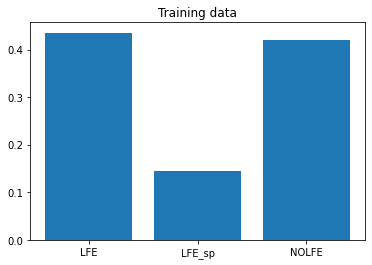

In [58]:
integer_labels=[np.argmax(y, axis=None, out=None) for y in Y_train]
distr = Counter(integer_labels)
figure, axes = plt.subplots()
axes.set_xticks([0,1,2])
axes.set_xticklabels(np.unique(ttl_labels))
vals=np.array(list(distr.values()))
nrmlz_vals=vals/np.sum(vals)
axes.bar(list(distr.keys()), nrmlz_vals);
axes.set_title('Training data')

Text(0.5, 1.0, 'Testing data')

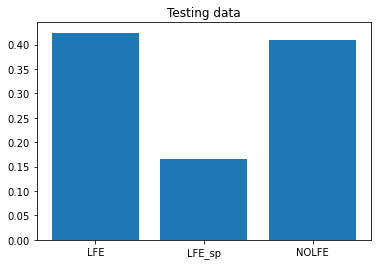

In [59]:
integer_labels=[np.argmax(y, axis=None, out=None) for y in Y_test]
distr = Counter(integer_labels)
figure, axes = plt.subplots()
axes.set_xticks([0,1,2])
axes.set_xticklabels(np.unique(ttl_labels))
vals=np.array(list(distr.values()))
nrmlz_vals=vals/np.sum(vals)
axes.bar(list(distr.keys()), nrmlz_vals);
axes.set_title('Testing data')

# Training the Model.

#### Model Architecture.

Here we choose the architecture of the model. 

Building on our FFNN, our model now has 2D convolutional layers and 2D max pooling layers.

In the convolutional layer, a 2D kernel of specified size is applied to sections of the input array. It performs element wise multiplication and returns the sum as a single pixel for each section of the input. The 2D array or matrix is transformed from its full size to to a 2D matrix of features.
The max pooling layer is applied after the convolution. It also uses a kernel of specified size that is applied to sections of the input array. The maximum value of the given section in the feature map is selected and returned, thus the dimensionality is reduced.

We apply a dropout layer, which randomly sets nodes in the hidden layers to zero at a rate of 0.2. The inputs are flattened before being fed into the hidden layers.

The first 2 hidden layers transform the original features into a new feature vectors of size 30.
The last layer essentially does the classification using multinomial regression based on these new features, we use a 'softmax' activation function with 3 nodes.
Softmax allows us to interpret the predictions as the probability of each class.


In [76]:
#Image input.
main_input = tf.keras.layers.Input(shape=(399,399,8))
#Latitude Input
latitude_input_1= tf.keras.layers.Input(shape=(1))
latitude_input_2= tf.keras.layers.Input(shape=(1))
#Local Time Input
lt_input_1= tf.keras.layers.Input(shape=(1))
lt_input_2= tf.keras.layers.Input(shape=(1))

#,strides=1,kernel_initializer='he_uniform',
conv1=Conv2D(8,(1,5), activation='relu',padding='valid')(main_input)
bn1=BatchNormalization(axis=-1)(conv1)
mp1=MaxPooling2D((1, 5))(bn1)
do1 = Dropout(0.3)(mp1)
#conv2=Conv2D(2,(1,5), activation='relu')(do1)
#bn2=BatchNormalization(axis=-1)(conv2)
#mp2=MaxPooling2D((2, 4))(bn2)
#do2 = Dropout(0.2)(mp2)
#conv3=Conv2D(48, (1, 5), activation='relu')(do2)
#bn3=BatchNormalization(axis=-1)(conv3)
#mp3=MaxPooling2D((2, 4))(bn3) 
#do3 = Dropout(0.3)(mp3)

#inputs = tf.keras.layers.Input(shape=(48, 1240, 8))
f1 = Flatten()(do1)
lastinput = tf.concat([f1, latitude_input_1, latitude_input_2, lt_input_1, lt_input_2], axis=1)
#x=Dropout(0.3)(lastinput)
x = tf.concat([lastinput, latitude_input_1, latitude_input_2, lt_input_1, lt_input_2], axis=1)
x = Dense(10, activation='relu',kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01))(x)
x=Dropout(0.3)(x)
x = Dense(25, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

In [77]:
# we create the model 
model = tf.keras.models.Model(inputs=[main_input,latitude_input_1, latitude_input_2, lt_input_1, lt_input_2 ], outputs=predictions)

# optimizer
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6, momentum=0.9)
#opt='Adam'

# compile
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#if (model.count_params() > 10,000,000):    
 #raise("Your model is unecessarily complex, scale down!")

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 399, 399, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 399, 395, 8)  328         ['input_36[0][0]']               
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 399, 395, 8)  32         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                           

In [78]:
# we create a callback function to plot our loss function and accuracy
pltCallBack = PlotLossAccuracy()

#### Computing the relative weights of each class to the total 

In [79]:
classWeight = skl.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(integer_labels),y=integer_labels) 
classWeight = dict(enumerate(classWeight))
print(classWeight)

{0: 0.7857142857142857, 1: 2.0, 2: 0.8148148148148148}


#### Fitting the model.

#### We use this function to convert the labels to binary vectors [1,0,0] (LFE) or [0,1,0] (LFE_ext) and [0,0,1] (NoLFE) in order to use softmax.

In [80]:
ttl_train = [X_train, lat_medians_train, lat_stds_train, lt_medians_train, lt_stds_train]
ttl_test=[X_test, lat_medians_test, lat_stds_test, lt_medians_test, lt_stds_test]

In [81]:
test_model=[X_train[0:12,:,:,:], lat_medians_train[0:12], lat_stds_train[0:12], lt_medians_train[0:12], lt_stds_train[0:12]]
test_model_y =Y_train[0:12]

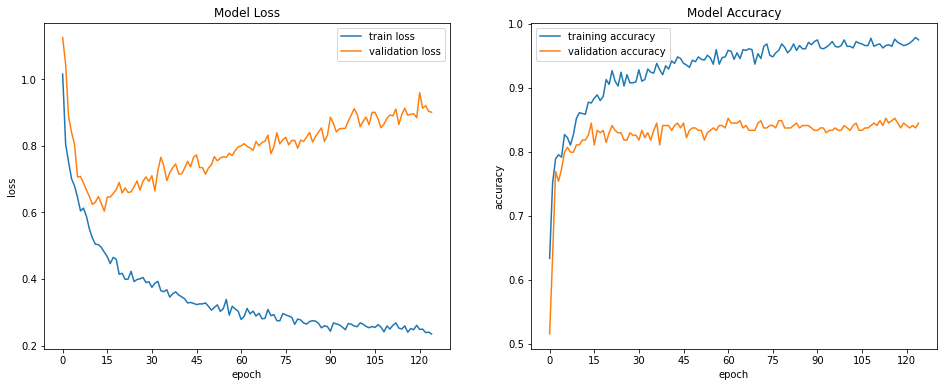

25/25 [==============================] - 21s 859ms/step - loss: 0.2347 - accuracy: 0.9747 - val_loss: 0.9002 - val_accuracy: 0.8447


In [83]:
model.fit(ttl_train, Y_train,
          batch_size=32,validation_split=0.25, epochs=125,shuffle=True,   
         callbacks=[pltCallBack], class_weight=classWeight)

#### Computing the loss and accuracy of the train and the test set on the trained model.

In [34]:
print("Train Loss:"+ str(model.evaluate(ttl_train, Y_train, verbose=0)[0])+" Train Accuracy:" +str(model.evaluate(ttl_train, Y_train, verbose=0)[1]))
ttl_test=[X_test, lat_medians_test, lat_stds_test, lt_medians_test, lt_stds_test]
print("Test Loss:"+ str(model.evaluate(ttl_test,Y_test, verbose=0)[0])+" Test Accuracy:" +str(model.evaluate(ttl_test, Y_test, verbose=0)[1]))

Train Loss:0.2957659661769867 Train Accuracy:0.9607362151145935
Test Loss:0.5537351965904236 Test Accuracy:0.8676470518112183


### Layer Visualization

[0. 0. 1.]


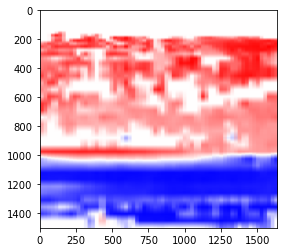

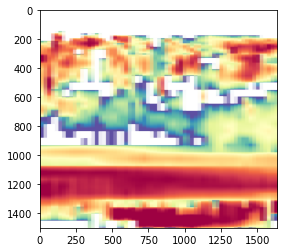

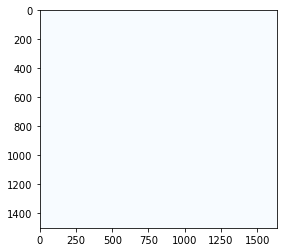

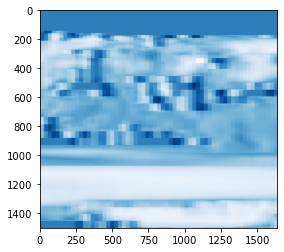

In [35]:
# Before I forget: a bit of code to get predictions at a layer from my trained model (model_base)
# dropout_2’ is the name of the layer for which I want predictions - one should use better names
# If you have the weights saved you can load them: model_base.load_weights(“Kats_model.h5")
# To save weights froma trained model: model_base.save_weights(“Kats_model.h5")
#define model:

# data_same_shape_as_training_set_at_input can be your trainingset or test set of whetever data you want predictions 
# Before I forget: a bit of code to get predictions at a layer from my trained model (model_base)
# dropout_2’ is the name of the layer for which I want predictions - one should use better names
# If you have the weights saved you can load them: model_base.load_weights(“Kats_model.h5")
# To save weights froma trained model: model_base.save_weights(“Kats_model.h5")
#define model:

# data_same_shape_as_training_set_at_input can be your trainingset or test set of whetever data you want predictions 
#intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                    #outputs=model.get_layer('conv2d_17').output)
#new_features = intermediate_layer_model.predict(ttl_train)


layer_names = [layer.name for layer in model.layers]
conv_layer_names = [i for i in layer_names if 'conv' in i]
conv_layers = [model.get_layer(i) for i in conv_layer_names]
successive_outputs = [layer.output for layer in conv_layers]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
successive_feature_maps = visualization_model.predict(ttl_train)
#print(successive_feature_maps[0].shape)
#Pick image to plot

item=6
print(Y_train[item])
pol_test = X_train[item, :, :,4:].copy()
pol_test = tf.image.resize(pol_test, [1500, 1640], method='nearest')
plt.imshow(pol_test)
plt.show()

flux_test = X_train[item, :, :,0:4].copy()
flux_test = tf.image.resize(flux_test, [1500, 1640], method='nearest')
plt.imshow(flux_test)

j=successive_feature_maps[item]
for i in range(j.shape[-1]):
    test = j[:,:,i:i+1].copy()
    test = tf.image.resize(test, [1500, 1640], method='nearest')
    fig, ax = plt.subplots(nrows=1, ncols=1)
    #ax.set_title()
    ax.imshow(test, cmap='Blues')
    plt.show()


### Plotting the Confusion Matrix.

The confusion matrix is an $\textbf{n}\times\textbf{n}$ matrix (n=number classes) that summarises the accuracy of the classifications made by the model. 

The rows of the matrix represent the actual classes and the columns represent the predicted classes. It allows us to see very clearly how often values are classified correctly, and also how it might misclassify a value.

In [41]:
#Convert Y labels back to integer classes
labels = Y_test
integer_labels=[np.argmax(y, axis=None, out=None) for y in labels]
predictions = model.predict(ttl_test)
#Class Predictions, based on the maximum probability, converted to integer classes,
class_predictions=[np.argmax(y, axis=None, out=None) for y in predictions]
#Confusion matrix
confus_matr=tf.math.confusion_matrix(
    integer_labels, class_predictions, num_classes=3).numpy()
print('Confusion Matrix',confus_matr)

Confusion Matrix [[39  7  1]
 [13 51  0]
 [ 3  3 87]]


#### Normalize each row by the number of values of each class in the test set.

In [42]:
con_mat_norm = np.around(confus_matr.astype('int') / confus_matr.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm)

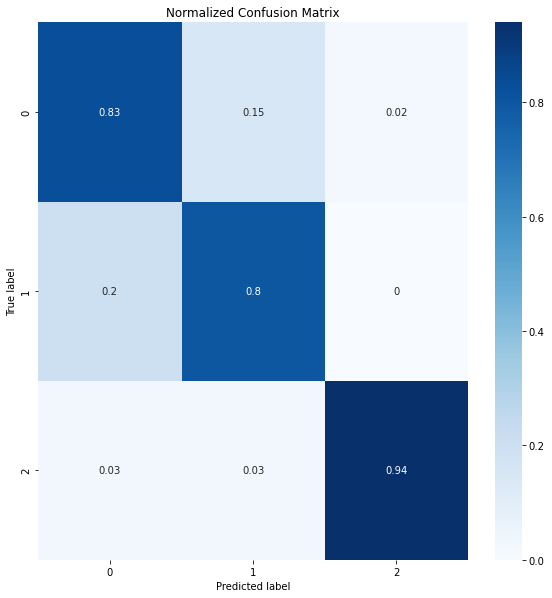

In [43]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Normalized Confusion Matrix')
plt.show()

### Plotting the ROC Curve.

The Receiver Operating Curve ($\textbf{ROC}$) is a another measure of the accuracy of the classification model. It is plotted as True Positive Rate vs False Positive Rate.

The False Positive Rate ($\textbf{FPR}$) is the probability that a negative value will be predicted as a positive.
$\textbf{FPR}$ is computed as $\frac{FP}{FP+TN}$  where $\textbf{FP}$ = number of false positives (negative predicted as positive),
and $\textbf{TN}$ is the number of true negatives (negative predicted as negative). The denominator is the 
total number of values in dataset - total number of given class.

The True Positive Rate ($\textbf{TPR}$) is the probability that a positive will be predicted as a positive.
$\textbf{TPR}$ is computed as $\frac{TP}{TP+FN}$ where $\textbf{TP}$ = number of true positives (positive predicted as positive),
and $\textbf{FN}$ is the number of false negatives (positive predicted as negative). The denominator is the 
total number of values in the given class.

We use the scikitlearn function $\textbf{metrics.roc_curve}$ to make this plot. The functions returns 3 arrays: the false positive rate ($\textbf{fpr}$), the true positive rate ($\textbf{tpr}$) and the $\textbf{thresholds}$ used to compute them. 


- $\textbf{fpr}$ is the false positive rate in increasing order, each value is the false positive
rate of predictions such that $\textbf{fpr}$[i] is the $\textbf{fpr}$ with score $\geq$ threshold[i]

- $\textbf{tpr}$ is the true positive rate in increasing order, each value is the true positive
rate of predictions such that $\textbf{tpr}$ is the $\textbf{tpr}$ with score $\geq$ threshold[i]

- $\textbf{thresholds}$  are used when computing the $\textbf{FPR/TPR}$. We need a threshold to decide whether or not a value is correctly predicted e.g probability $>$ 0.7 is a correct prediction. It is returned in decreasing order. The first value is arbitrarily set to be max(predictions) + 1. It is computed as that to ensure no instances are predicted.

We plot the $\textbf{ROC}$ curve for each class and also compute the area under curve ($\textbf{AUC}$) of each curve.

In [64]:
# Compute ROC curve and ROC area for each class

#Convert Y labels back to integer classes
labels = Y_test
integer_labels=[np.argmax(y, axis=None, out=None) for y in labels]
predictions = model.predict(ttl_test)

n_classes = len(np.unique(integer_labels))
fpr = dict()
tpr = dict()
roc_auc = dict() #area under the roc curve
for i in range(n_classes):
    fpr[i], tpr[i], thresh = roc_curve(labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

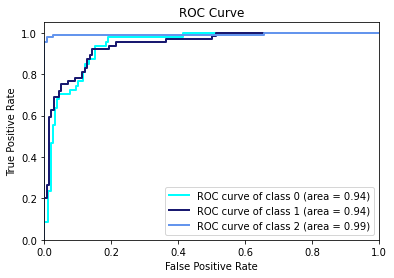

In [65]:
# Plot all ROC curves
plt.figure()
lw = 2 #linewidth

colors = cycle(["aqua", "midnightblue", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

#plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

### Viewing misclassified Images.

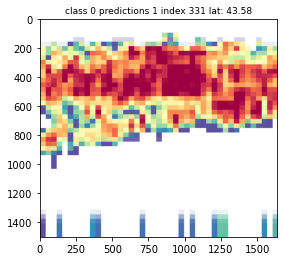

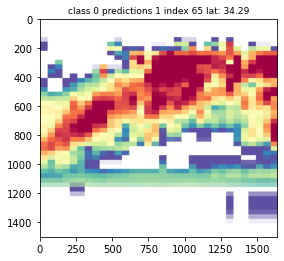

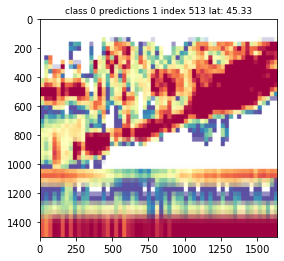

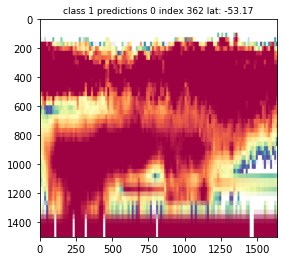

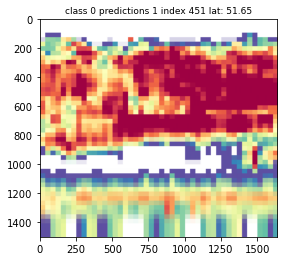

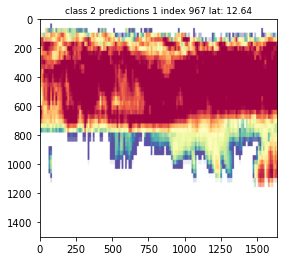

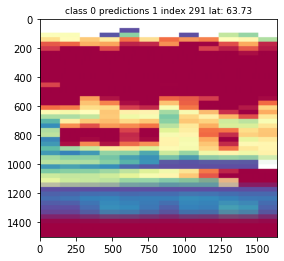

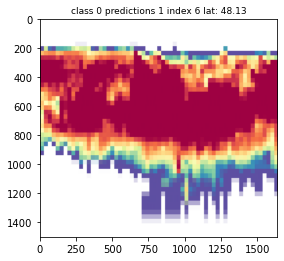

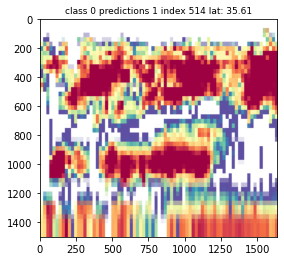

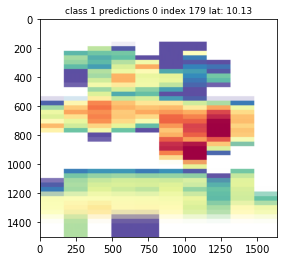

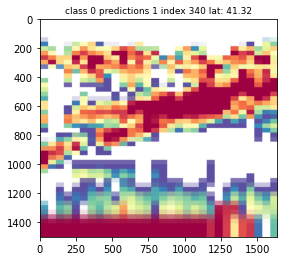

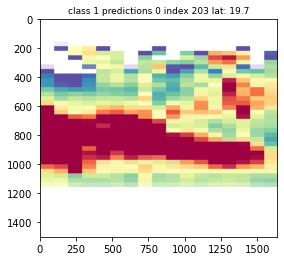

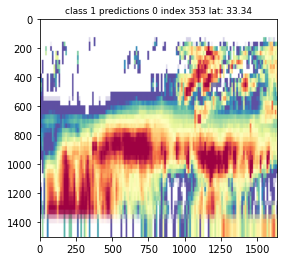

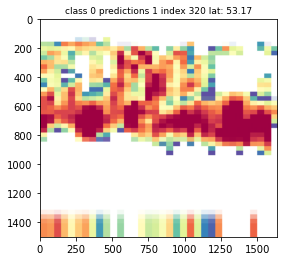

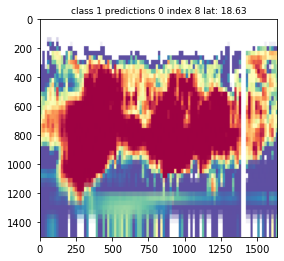

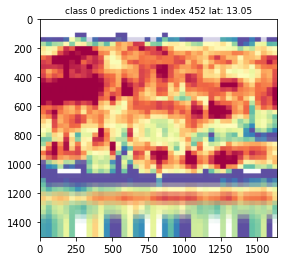

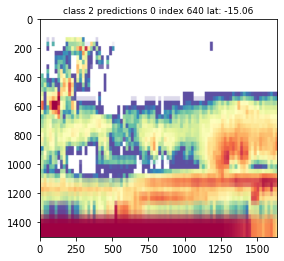

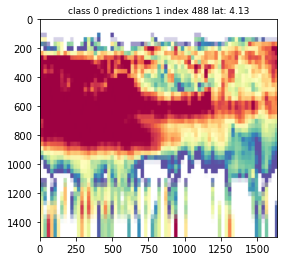

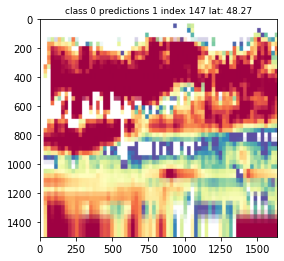

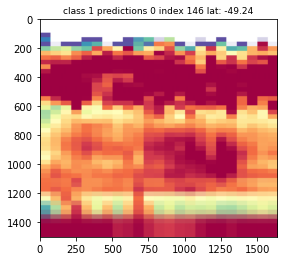

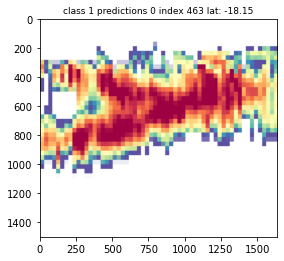

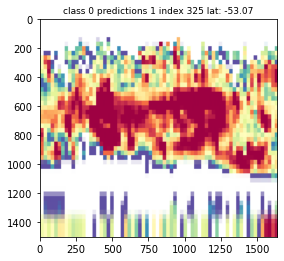

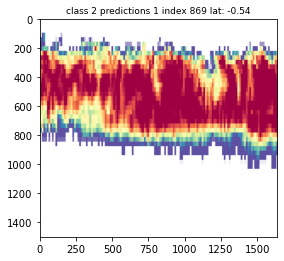

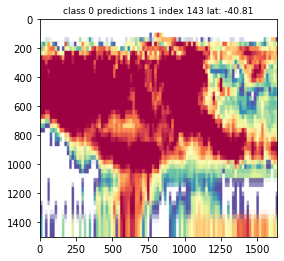

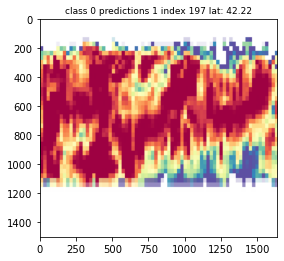

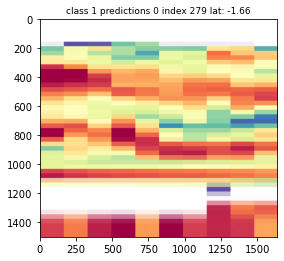

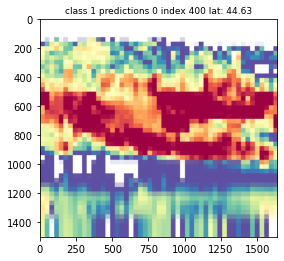

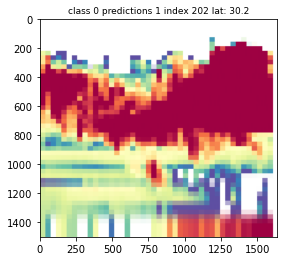

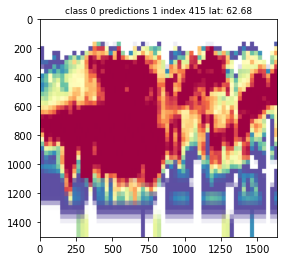

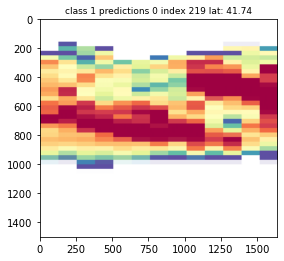

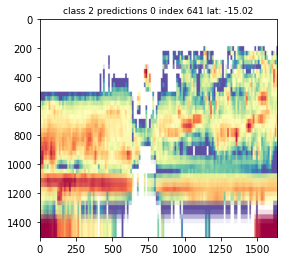

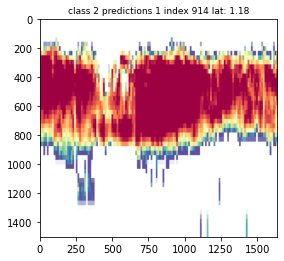

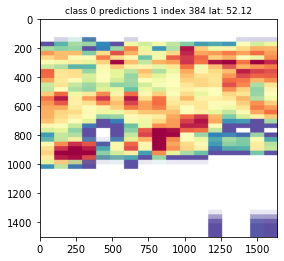

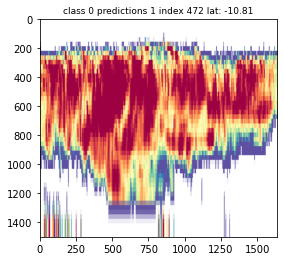

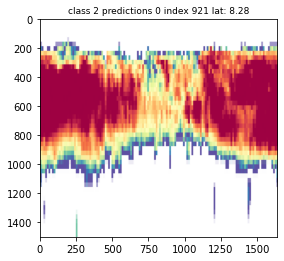

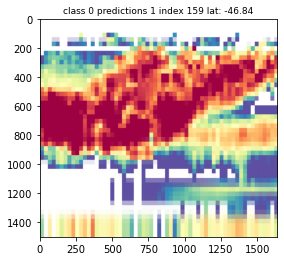

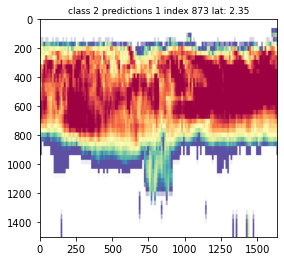

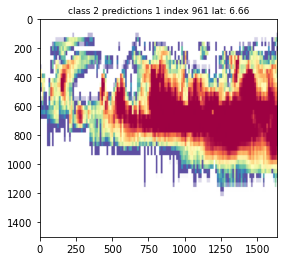

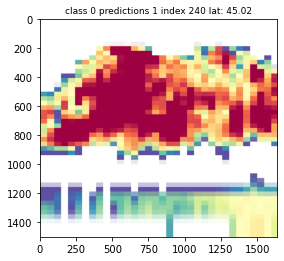

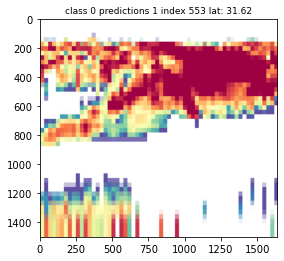

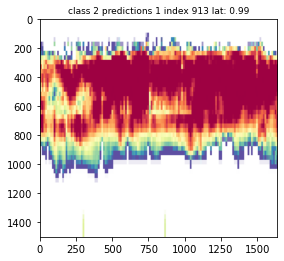

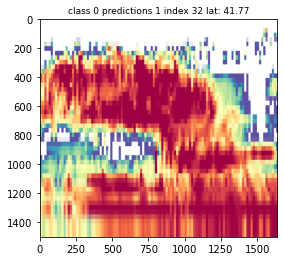

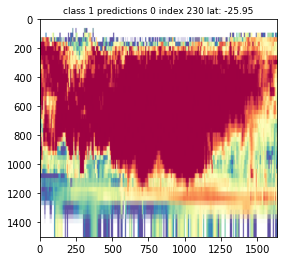

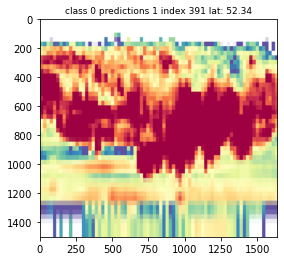

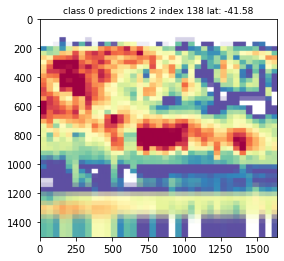

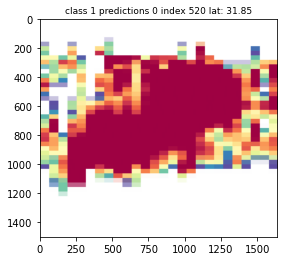

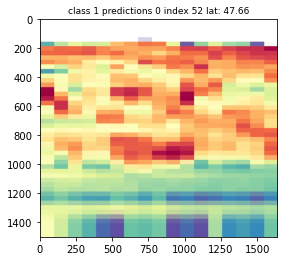

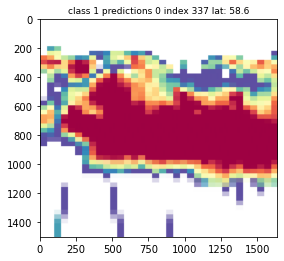

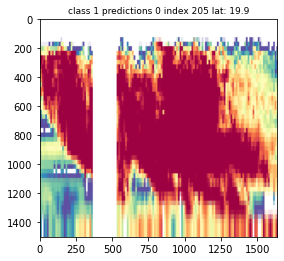

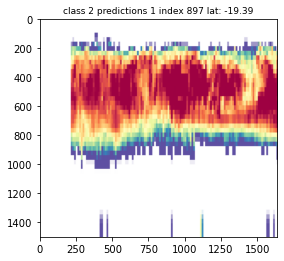

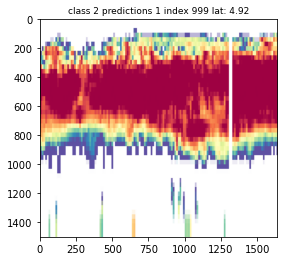

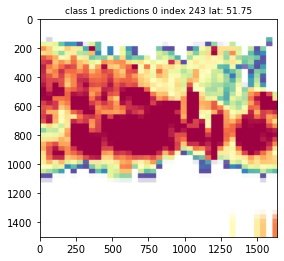

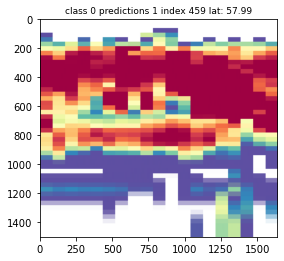

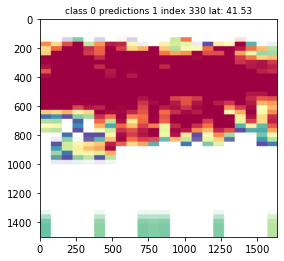

In [67]:
Train_predictions = model.predict(ttl_train)
int_train_Predictions=np.array([np.argmax(y, axis=None, out=None) for y in Train_predictions])
int_Y_train = np.array([np.argmax(y, axis=None, out=None) for y in Y_train])
#
#for finding misclassified image
result = np.array([np.absolute(i-j) for i, j in zip(int_Y_train, int_Predictions)])
misclassified = [j for i, j in enumerate(result) if j > 0]
latmedianstrain =[(160 * i)-80 for i in lat_medians_train] 
train_indices_misclassified = np.array([i for i, j in enumerate(result) if (j > 0)])

#test_predictions=model.predict(ttl_test)
#int_test_Predictions=np.array([np.argmax(y, axis=None, out=None) for y in test_predictions])
#int_Y_test = np.array([np.argmax(y, axis=None, out=None) for y in Y_test])
#result_test = np.array([np.absolute(i-j) for i, j in zip(int_Y_test, int_test_Predictions)])
#test_misclassified = [j for i, j in enumerate(result_test) if j > 0]
#latmedianstest =[(160 * i)-80 for i in lat_medians_test] 

#index of misclassified image within test/train data#
#test_indices_misclassified = np.array([i for i, j in enumerate(result_test) if (j > 0)])


for i in train_indices_misclassified:
    test = X_train[i,:,:,0:4].copy()
    a = tf.image.resize(test, [1500, 1640], method='nearest')
    fig, ax = plt.subplots(1, 1)
    ax.imshow(a)
    
    ax.set_title('class '+str(int_Y_train[i])+ ' predictions ' + str(int_train_Predictions[i]) + ' index ' + str(indices_train[i])+' lat: '+str(np.round(latmedianstrain[i],2)),fontsize=9)
    plt.show()

Years of Misclassified Examples.

['2004' '2004' '2004' '2004' '2012' '2012' '2012' '2012' '2012' '2012'
 '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012'
 '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012'
 '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012'
 '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012' '2012'
 '2012' '2012' '2012' '2012']


Text(0, 0.5, 'Counts')

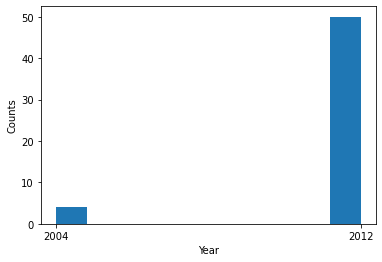

In [69]:
result = np.array([np.absolute(i-j) for i, j in zip(int_Y_train, int_Predictions)])
misclassified = [j for i, j in enumerate(result) if j > 0]

years_misclassified = np.sort([years_train[i] for i in misclassified])
print(years_misclassified)
fig, ax = plt.subplots(1, 1)
ax.hist(years_misclassified)
ax.set_xlabel('Year')
ax.set_ylabel('Counts')

### Latitude Distribution of Classes

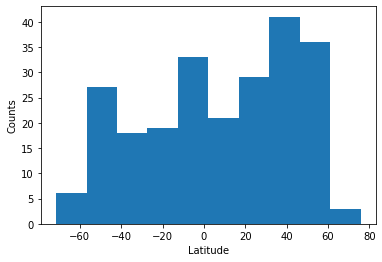

In [70]:
int_Y_train = np.array([np.argmax(y, axis=None, out=None) for y in Y_train])
indices_lfe = [i for i, j in enumerate(int_Y_train) if j == 1]
latitude_lfe_ext = [lat_medians_train[i] for i in indices_lfe]
latitude_unnorm = [(160 * i)-80 for i in latitude_lfe_ext]
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(latitude_unnorm)
ax.set_xlabel('Latitude')
ax.set_ylabel('Counts')
plt.show()

## Discussion

- The CNN used in this notebook did not perform as well as previous models. In the accuracy loss plot we can see how the validation accuracy converges at $\sim$ 0.7 whilst the training accuracy continues to increase (perhaps overfitting). Despite this, the loss in both cases decreases quite consistently.

- Overall, the model produced a training accuracy of 0.80 and a testing accuracy of 0.74.

- The confusion matrix revealed that the model classifies typical LFEs extremely well (96$\%$) but misclassifies LFEs with high frequency extinction nearly $50\%$ of the time. The model commonly misclassifies extinction LFEs and Non-LFEs as LFEs.

- We visualise some of the misclassified images at the end of the notebook. We see examples of misclassfied LFE_ext and see that they are not fully extinct, just with low intensity at high frequency in some cases. It is easy to see how the model doesn't differentiate well between the two.  

- Including the latitude and local time data, aswell as the augmented images, hasn't dramatically increased the model accuracy. It would be useful to include this information in the FFNN and see how it impacts the results.

- Since the model regularly misclassifies LFE_ext as LFE, it would be interesting to do a classification model for just those two classes and visualise what the layers are doing for that case.
